# 📊 Model Evaluation & Error Analysis
Notebook này được tạo riêng để đánh giá chi tiết hiệu suất của mô hình trên tập test.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load dữ liệu predictions test
pred_file = "results/predictions_test.csv"

if os.path.exists(pred_file):
    df_pred = pd.read_csv(pred_file)
    print(f"✅ Đã load thành công dữ liệu Predictions! ({len(df_pred)} mẫu)")
    display(df_pred.head(3))
else:
    print(f"⚠️ Không tìm thấy file {pred_file}")
    df_pred = pd.DataFrame()

✅ Đã load thành công dữ liệu Predictions! (24 mẫu)


,text,summary,url,predicted_summary
0,VPBankS dự kiến thu 12.700 tỷ đồng khoảng 483 ...,VPBankS dự kiến thu 12.700 tỷ đồng khoảng 483 ...,https://vnexpress.net/chung-khoan-vpbank-du-ki...,Đại diện VPBankS dự kiến thu 12.700 tỷ đồng kh...
1,"Nhiều mặt hàng từ thời trang , tủ bếp đến ghẹ ...","Nhiều mặt hàng từ thời trang , tủ bếp đến ghẹ ...",https://vnexpress.net/xuat-khau-det-may-noi-th...,Công Thương dự báo xuất khẩu về đích năm nay v...
2,Reuters trích nguồn tin cho biết chính quyền ô...,Reuters trích nguồn tin cho biết chính quyền ô...,https://vnexpress.net/ong-trump-muon-ap-thue-v...,Thanh Niên Online trích nguồn tin cho biết chí...


## 1. Tính toán ROUGE Scores

In [22]:
# Cài đặt thư viện cần thiết nếu chưa có
# !pip install rouge_score wordcloud

from rouge_score import rouge_scorer
from wordcloud import WordCloud

# Hàm tính ROUGE score
def calculate_rouge(row):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    if pd.isna(row['summary']) or pd.isna(row['predicted_summary']):
        return pd.Series({'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0})
        
    scores = scorer.score(str(row['summary']), str(row['predicted_summary']))
    return pd.Series({
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    })

if not df_pred.empty:
    print("🚀 Đang tính toán ROUGE scores...")
    rouge_scores = df_pred.apply(calculate_rouge, axis=1)
    df_pred = pd.concat([df_pred, rouge_scores], axis=1)
    
    print("\n📊 Thống kê ROUGE Scores:")
    display(df_pred[['rouge1', 'rouge2', 'rougeL']].describe().round(4))

🚀 Đang tính toán ROUGE scores...

📊 Thống kê ROUGE Scores:


,rouge1,rouge2,rougeL
count,24.0000,24.0000,24.0000
mean,0.8910,0.8431,0.8663
std,0.1298,0.2346,0.1918
min,0.4952,0.0971,0.2476
25%,0.8687,0.8588,0.8687
50%,0.9502,0.9477,0.9502
75%,0.9677,0.9670,0.9677
max,1.0000,1.0000,1.0000


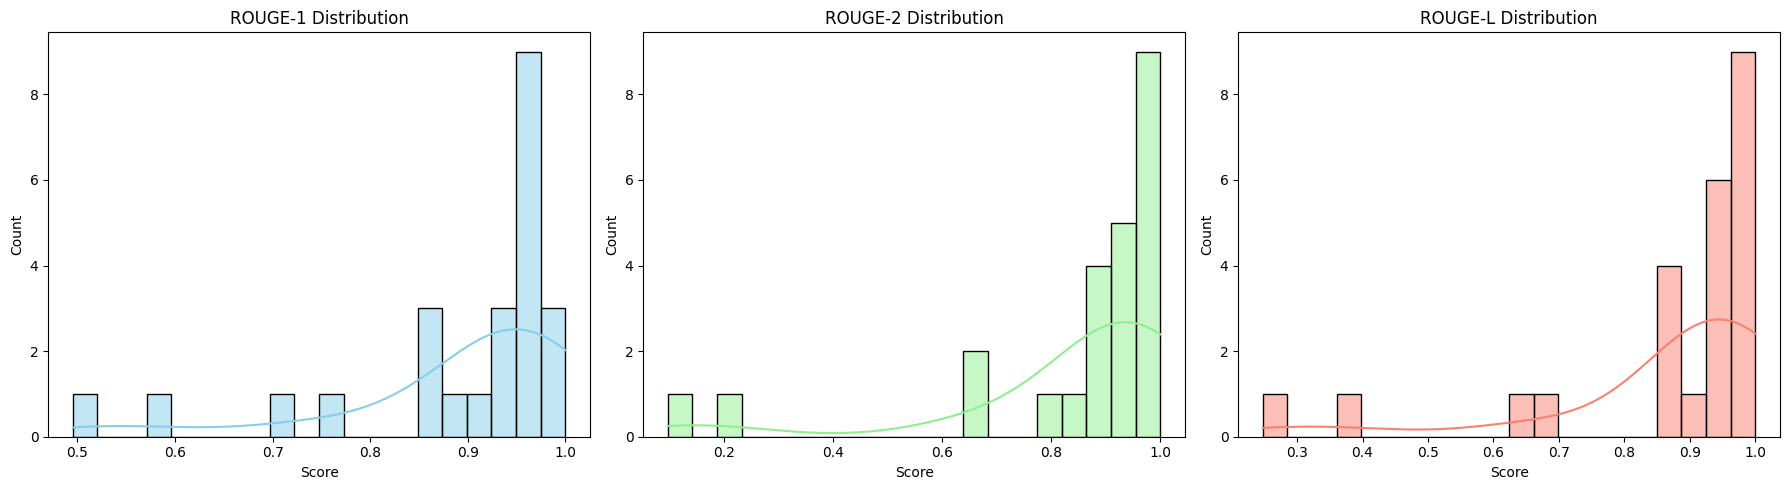

In [23]:
if not df_pred.empty and 'rouge1' in df_pred.columns:
    # Visualize ROUGE distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors = ['skyblue', 'lightgreen', 'salmon']
    metrics = ['rouge1', 'rouge2', 'rougeL']
    titles = ['ROUGE-1 Distribution', 'ROUGE-2 Distribution', 'ROUGE-L Distribution']
    
    for i, metric in enumerate(metrics):
        sns.histplot(df_pred[metric], bins=20, kde=True, ax=axes[i], color=colors[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Count')
        
    plt.tight_layout()
    plt.show()

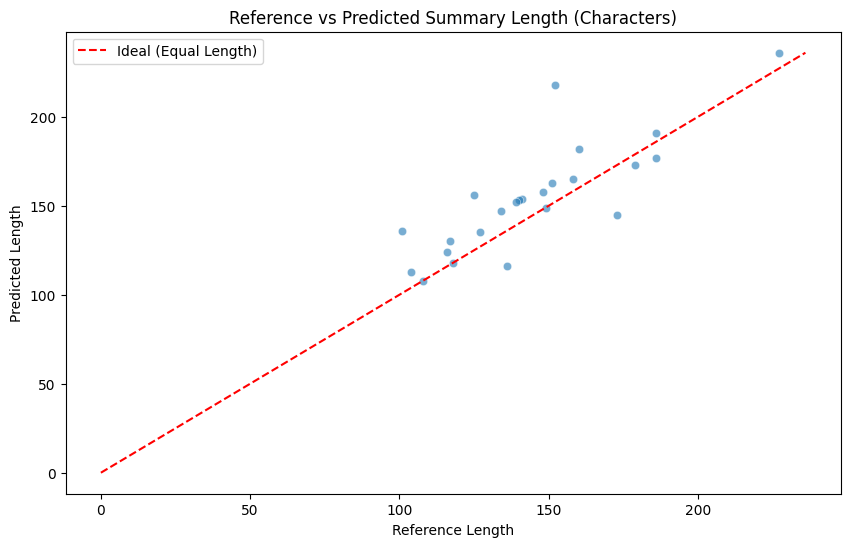

🔗 Correlation between reference and predicted lengths: 0.8254


In [24]:
if not df_pred.empty:
    # Length Comparison
    df_pred['ref_len'] = df_pred['summary'].astype(str).str.len()
    df_pred['pred_len'] = df_pred['predicted_summary'].astype(str).str.len()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pred, x='ref_len', y='pred_len', alpha=0.6)
    
    # Add diagonal line
    max_val = max(df_pred['ref_len'].max(), df_pred['pred_len'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal (Equal Length)')
    
    plt.title('Reference vs Predicted Summary Length (Characters)')
    plt.xlabel('Reference Length')
    plt.ylabel('Predicted Length')
    plt.legend()
    plt.show()
    
    # Correlation
    corr = df_pred['ref_len'].corr(df_pred['pred_len'])
    print(f"🔗 Correlation between reference and predicted lengths: {corr:.4f}")

In [25]:
if not df_pred.empty and 'rouge1' in df_pred.columns:
    # Best and Worst Examples
    print("🏆 Top 3 Best Summaries (by ROUGE-1):")
    top_3 = df_pred.nlargest(3, 'rouge1')
    for idx, row in top_3.iterrows():
        print(f"\nExample {idx} (ROUGE-1: {row['rouge1']:.4f}):")
        print(f"Ref:  {row['summary']}")
        print(f"Pred: {row['predicted_summary']}")
        print("-" * 80)
        
    print("\n⚠️ Top 3 Worst Summaries (by ROUGE-1):")
    bottom_3 = df_pred.nsmallest(3, 'rouge1')
    for idx, row in bottom_3.iterrows():
        print(f"\nExample {idx} (ROUGE-1: {row['rouge1']:.4f}):")
        print(f"Ref:  {row['summary']}")
        print(f"Pred: {row['predicted_summary']}")
        print("-" * 80)

🏆 Top 3 Best Summaries (by ROUGE-1):

Example 15 (ROUGE-1: 1.0000):
Ref:  Tổng thống Mỹ công bố thuế mới từ 25-100 với nhiều loại thuốc , xe tải , đồ nội thất , áp dụng từ tháng 10 .
Pred: Tổng thống Mỹ công bố thuế mới từ 25-100 với nhiều loại thuốc , xe tải , đồ nội thất , áp dụng từ tháng 10 .
--------------------------------------------------------------------------------

Example 21 (ROUGE-1: 0.9831):
Ref:  TP HCM - Tổng hội Liên hiệp Doanh nghiệp Khu Công nghiệp Đài Loan tổ chức kết nối , mở rộng thị trường cho doanh nghiệp thực phẩm , giúp đa dạng sản phẩm cho người dùng Việt , sáng 249 .
Pred: Tổng hội Liên hiệp Doanh nghiệp Khu Công nghiệp Đài Loan tổ chức kết nối , mở rộng thị trường cho doanh nghiệp thực phẩm , giúp đa dạng sản phẩm cho người dùng Việt , sáng 249 .
--------------------------------------------------------------------------------

Example 17 (ROUGE-1: 0.9748):
Ref:  Ông Trump dành gần một tiếng đồng hồ nói về biến đổi khí hậu , năng lượng tái tạo , gọi đây là 

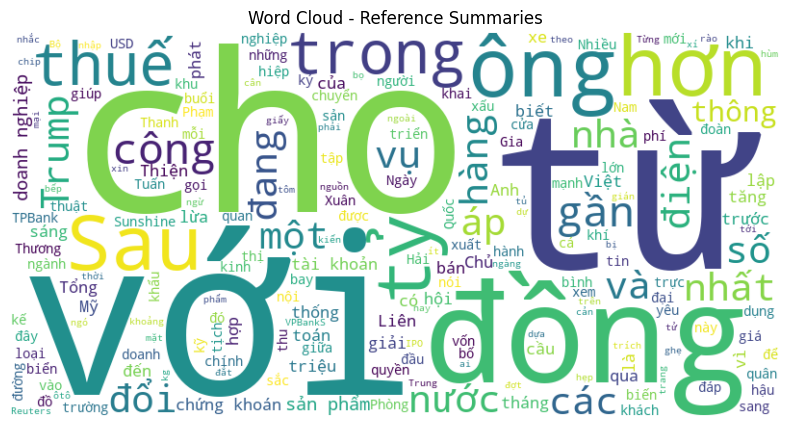

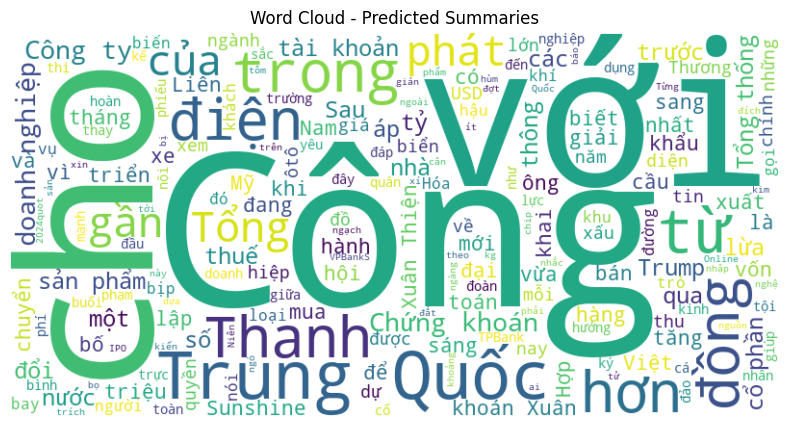

In [26]:
if not df_pred.empty:
    # Word Clouds
    def plot_wordcloud(text_series, title):
        text = ' '.join(text_series.astype(str))
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(title)
            plt.show()
        except Exception as e:
            print(f"Could not generate wordcloud: {e}")

    plot_wordcloud(df_pred['summary'], 'Word Cloud - Reference Summaries')
    plot_wordcloud(df_pred['predicted_summary'], 'Word Cloud - Predicted Summaries')